# Inspecting the Alpha Zero V13 MCTS data

There seems to be some flaw in the MCTS algorithm. Maybe the value is wrong?
This will inspect the data generated by KSquares' AlphaZeroMCTS AI for a 3x3 board.

First, we will load the dataset that was generated with the first self-play network. That network first received training on 2.000.000 examples generated with the Hard AI (this network version is called init-network) and then trained on 128 examples that were generated with MCTS using the init-network.

In [1]:
import sys

import numpy as np

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random
import gc

data_path = 'StageFour-AlphaZero3x3-2018-07-08-17-39-57-SP-it1500-dir0.030000-c:10.000000-128-3x3-sig0.200000-mean0.600000-20:55-08_07_2018.npz'

## Load data
First we have to load the data that was generated. It is a StageFour dataset, with input, policy and value data, generated in self-play.

In [2]:
dataset = np.load(data_path)

In [3]:
x_input = dataset['input']
y_policy = dataset['policy']
y_value = dataset['value']

In [4]:
print(x_input.shape)
print(y_policy.shape)
print(y_value.shape)

img_width = x_input.shape[-1]
img_height = x_input.shape[-2]

(128, 9, 9)
(128, 9, 9)
(128, 1)


In [5]:
def make_image(imgdata):
    #create image
    merged_imgdata = np.stack([imgdata, imgdata, imgdata], axis=2)
    img = Image.fromarray(merged_imgdata, 'RGB')
    img = img.resize(size=(img.size[0]*10, img.size[1]*10))
    return img

## Display the data
Here we print and display the data we just loaded from the example npz file. First we will look at the input and output data of the first example in the dataset.

## Input data

[[  0   0   0   0   0   0   0   0   0]
 [  0 215   0 215 255 215   0 215   0]
 [  0 255   0   0   0 255   0   0   0]
 [  0 215 255 215   0 215 255 215   0]
 [  0 255   0   0   0 255   0   0   0]
 [  0 215   0 215 255 215   0 215   0]
 [  0 255   0 255   0   0   0 255   0]
 [  0 215   0 215   0 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0]]


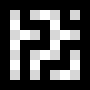

In [6]:
example = 1

print(x_input[example])
make_image(x_input[example])

### Input data analysis
There is a board with two long chains and a short chain. All we have to do is open the short chain to give it to our opponent who will then have to open one of the long chains. Thus we gain control of the game and win 6 to 3. 

Further down there is a version of this board as it would look in KSquares. It might be easier to view it in a more classical rendering.

## Output data

[[  0   0   0   0   0   0   0   0   0]
 [  0   0 255   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]
[0.97533702]


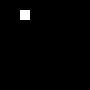

In [7]:
print(y_policy[example])
print(y_value[example])
make_image(y_policy[example])

### Output data analysis
Ok, this looks bad. The value is fine, it reflects our very high chance to win the game IF we do the right thing. But the policy says to open a long chain! That is plain wrong and will lose the game for certain. Our opponent just has to take the chain, open the short chain and will get the other long chain, winning 8 to 1.

## MCTS Analysis

We will now analyse the MCTS algorithm in KSquares. The following picture depicts the game in KSquares with line numbers in light gray. Horizontal lines are denoted below the respective line, vertical lines have their numbers on the left side of the line.

![First example in KSquares](mcts-debug-1.png)

As stated before, the correct policy would be to select either line 2 or 6. All other lines are wrong and will lose the game.

Run the following test to execute the AlphaZero MCTS algorithm with AlphaZeroV13, AlphaZeroV13_SP and AlphaZeroV13_SP2 on the depicted board and receive debug data in /tmp

```
ksquarestest alphazero -- testAlphaZero005
```

When you run the test, it will pass for V13 and fail for V13_SP and V13_SP2. That's not good, since the SP (self-play) versions are supposed to be better than before, not worse.

You will find a .dot and a .txt file named AlphaZeroMCTS$TIMESTAMP.[dot|txt] for each run in your /tmp directory. The .txt file just contains a ascii version of the input board, while the .dot file can be rendered with graphviz to create a PDF of the Monte-Carlo tree:

```
for file in $(ls -t /tmp/AlphaZeroMCTS*dot); do echo "converting $file..."; dot -Tpdf $file -o $file.pdf; done;
```

Run the test `testAlphaZero006` to get the direct neural network outputs from V13, V13_SP and V13_SP2 on the shown board:


```
V13:
[[0.22]]
[[[  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0 183   0   0]
  [  0   0   0   0   0   0   0  71   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]]]

V13_SP:
[[0.71]]
[[[ 0  0  0  0  0  0  0  0  0]
  [ 0  0 18  0  0  0 20  0  0]
  [ 0  0  0 25  0  0  0 23  0]
  [ 0  0  0  0 24  0  0  0  0]
  [ 0  0  0 20  0  0  0 17  0]
  [ 0  0 19  0  0  0 22  0  0]
  [ 0  0  0  0  0 20  0  0  0]
  [ 0  0 18  0 23  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0]]]

V13_SP2:
[[0.33]]
[[[ 0  0  0  0  0  0  0  0  0]
  [ 0  0 14  0  0  0 16  0  0]
  [ 0  0  0 20  0  0  0 16  0]
  [ 0  0  0  0 25  0  1  0  0]
  [ 0  0  0 19  0  0  0 16  0]
  [ 0  0 31  0  3  0 24  0  0]
  [ 0  0  0  0  0 20  0  0  0]
  [ 0  0 20  0 22  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0]]]
```

### MCTS with AlphaZeroV13
Here is the Monte-Carlo tree that was generated by the described test using AlphaZeroV13 that was only trained on data generated with the Hard AI. The values (**V**) for move two and six are the only values above zero, that's good.

The nodes have the following description from left to right:
* line number of the move described by that node - see the above image of the board for the line numbers. -1 represents the input state
* **V** value of that move
* **N** visit count
* **P** prior probability assigned by network
* **U** UCT value

![Monte-Carlo tree for the described problem](mcts-debug-1-tree.png)

### AlphaZeroV13_SP

This graph is far too large to be displayed here. So it has to be reduced first using gvpr with [this nice script](https://gist.github.com/blabber/74b8d9ed59d0b2ad0d7a734113996424) from the user "blabber" on github.

```
cd /tmp && wget https://gist.githubusercontent.com/blabber/74b8d9ed59d0b2ad0d7a734113996424/raw/3a838d1fd2210e52b967bc21a8ef4b075a30fe46/reduce.g 

for file in $(ls -t /tmp/AlphaZeroMCTS*dot); do echo "converting $file..."; gvpr -f /tmp/reduce.g -a $(head -n1 $file|egrep -o 'node[0-9a-z]+') -a 1 $file > $file-reduced.dot; dot -Tpdf $file-reduced.dot -o $file-reduced.pdf; done;

```

The following image shows the reduced graph. Only the direct children of the root node are visible.
Remarkably, all values are negative! Also the priors **P** (policy output of network) are very evenly distributed. The previous MCTS tree had a very strong prior on line number 2, which is very good. So training on 128 examples seemingly resulted in a serious degradation of the policy output of the network.

![reduced tree](mcts-debug-1-tree-reduced.png)

So maybe we need to take a look at the dataset that was generated before this one. That dataset was generated with the init-network and MCTS. The init-network is used in AlphaZeroV13.

In [8]:
data_path = 'StageFour-AlphaZero3x3-2018-07-08-17-39-57-it1500-dir0.030000-c:10.000000-128-3x3-sig0.200000-mean0.600000-20:27-08_07_2018.npz'
dataset = np.load(data_path)
x_input = dataset['input']
y_policy = dataset['policy']
y_value = dataset['value']
print(x_input.shape)
print(y_policy.shape)
print(y_value.shape)
img_width = x_input.shape[-1]
img_height = x_input.shape[-2]

(128, 9, 9)
(128, 9, 9)
(128, 1)


[[  0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0]
 [  0   0   0 255   0 255   0 255   0]
 [  0 215   0 215   0 215   0 215   0]
 [  0 255   0 255   0 255   0   0   0]
 [  0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0 255   0   0   0]
 [  0 215 255 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0]]


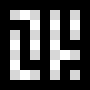

In [9]:
example = 4

print(x_input[example])
make_image(x_input[example])

[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]
[0.94689792]


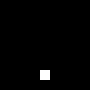

In [10]:
print(y_policy[example])
print(y_value[example])
make_image(y_policy[example])

That game looks as follows in KSquares:

![Second MCTS debug example](mcts-debug-2.png)

On the board there are two short chains on the right, one short chain in the middle and a long chain on the left. The winning move is to connect the long chain on the left with the short chain in the middle to create a chain made of 6 boxes. Our opponent will then have to make a move in either one of the other two short chains. We take that short chain, open the other one and finally get the 6 box long chain, thus winning the game.

The output looks very good - it has the correct move and a high value, inidicating a high chance to win the game. It might be possible that the value was generated with the old method in the StageFour data generator that used the Hard AI to complete the game after MCTS made its move - the new version takes the value of the selected Monte-Carlo tree node. So maybe MCTS calculates a value that is inferior? But even if that is the case, the training data has a good value and resulted in bad results. After all, we examine V13_SP which was trained on the presented data.

To get the MCTS tree from running MCTS with the init-network (V13) and the network that was trained in self-play with the presented dataset (V13_SP), run `ksquarestest alphazero -- testAlphaZero007` and again convert the .dot files in /tmp with
```
for file in $(ls -t /tmp/AlphaZeroMCTS*dot); do echo "converting $file..."; dot -Tpdf $file -o $file.pdf; done;
```

The resulting tree looks as follows for V13. The value on the root node is not correct, it should be close to 1. This resulted in a bugfix in MCTS so that the value of the root node is updated in addition to the visit count.

![Monte-Carlo tree for second example with V13](mcts-debug-2-tree.png)

Conversely, the tree from V13_SP looks vastly different. It is far bigger and has to be reduced to fit here.
Furthermore the values on all nodes are negative.

![Monte-Carlo tree for second example with V13_SP](mcts-debug-2-tree-sp.png)

The V13 network produces the following prediction for value and policy when faced with our second example. The policy values range from 0 to 255. The predicted value is wrong, it should be greater than 0, while the policy is on point.
```
[[-0.13]]
[[[  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]
  [  0   0   0   0 254   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0]]]
```

The V13_SP network produces the following prediction for value and policy:
```
[[0.82]]
[[[ 0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  9  0  8  0  0]
  [ 0 23  0  0  0  0  0  0  0]
  [ 0  0 15  0 17  0 19  0  0]
  [ 0  0  0  0  0  0  0 22  0]
  [ 0  0 19  0 20  0  0  0  0]
  [ 0  0  0 26  0  0  0 17  0]
  [ 0  0  0  0 27  0 24  0  0]
  [ 0  0  0  0  0  0  0  0  0]]]
```

The main difference between both predictions: the value is corrected while the policy is far more distributed, but still has the highest prediction on the correct line. So although the output is more diverse, MCTS should still produce the correct result, which it does not do for some reason.

Possible reason: When evaluating a MCTS leaf node its value is calculated by taking the network's predicted value and negating it if it's the opponent's turn. Maybe that's what went wrong all along?

* MCTS must invert value if it's the opponent's turn. This is already done
* During selection, MCTS must keep track of the current player according to position in the Monte-Carlo tree. This was missing!
* Also during backup the value must be inverted if it's the opponent's turn

## Changes to Alpha Zero MCTS in KSquares

* Invert value if it's the opponent's turn during backup -> value is player dependent
* Use move sequences instead of single lines -> this results in a change of player after each node. Generating move sequences has already been implemented for the bachelor's thesis.
* Terminal game states are scored directly (there was code for this in MCTS that didn't work due to a bug in aiBoard's drawnLineCnt - it wasn't initialized in one constructor)
* Improve debug tree:
    * Mark terminal game states with an ellipse
    * Mark opponent's turns by filling the node with a yellow background color

### Bug: Alternating players

Due to the move sequences, each level of the Monte-Carlo tree must have the same color. Each node represents a full turn that can include multiple lines.
Colors don't always alternate. For example in this tree for [Berlekamp's Test 3.2](Tests.html#berlekamp-002) the node's are colored wrong:

![Monte-Carlo tree for Berlekamp's Test 3.2](berlekamp-3-2-tree.png)

**Solution**: Undoing moves in backpropagation was done in the wrong order. The last move has to be undone first! Resulting tree looks far better. Most Berlekamp tests pass after the fix.

### Bug: Value in terminal node

[Berlekamp 3.3](Tests.html#berlekamp-003) still fails. The board looks as follows:

![Berlekamp Test 3.3 in KSquares](berlekamp-003-debug.png)

The only winning move is to make a preemtive sacrifice by drawing line 7. The Monte-Carlo tree has the highest value for move 7, but has a higher visit count for line 14. That's rather bad, because line 14 is a half-hearted handout, which most probably is wrong in any given situation and not only in this instance. When we make a half-hearted handout, we open a short chain on one of its ends. As a result, our opponent can choose to either capture the chain or apply double-dealing. Offering our opponent a choice is a very bad idea, because it gives away control of the game without gaining any advantage.

Let's take a look at the Monte-Carlo tree. It's rather big, so we will take a look on the two interesting parts of the tree directly afterwards.

![Monte-Carlo tree for Berlekamp 3.3](berlekamp-3-3-tree.png)

The interesting parts are those children of the root node that have a high visit count **N**. That's 7 and 14.

Let's look at the subtree for node 7. Here we see a bug: The final elliptic node in the middle has a negative value and it's parent has a negative value too. Since the player changes, the value should switch its sign.
![Monte-Carlo subtree node 7](berlekamp-3-3-subtree-7.png)

When we follow the path that leads to the mentioned node, we see that the node's value is wrong, but is backed up correctly through the tree. The wrong value in the final node is not that bad, because backup still works as expected. 

Bug has been fixed by always scoring the board from the AI's (our) perspective and using node->ownMove to decide if the value needs to be negated.

### Early preemtive sacrifices

Evaluation result:

AI|Games|Wins vs. Easy in 10 games|Wins vs. Medium in 10 games|Wins vs. Hard in 10 games 
---|---|---|---|---
AlphaZeroV14_MCTS|30|10|9|5

MCTS gives away boxes very early in the game without having any advantage from sacrificing them. It just does not know what to do and makes a bad decision. It's not that preemtive sacrifices are bad in general. But when taking a look at the Monte-Carlo tree it becomes clear that there is no clear cut advantage to do the sacrifices that early. There are still too many unexplored options to warrant a sacrifice.

Take a look at this [PDF](early-sacrifice-reduced.pdf) that shows a reduced Monte-Carlo tree for a situation where it gives away a box without seeing any advantage in the depicted situation. All nodes are visited about equally, only node 43 has seen twice as many visits. Unfortunately that move sacrifices a box.

```
+  +  +--+  +  +                          +  +  +--+  +  +
      |        |                                |        |
+--+--+  +  +  +                          +--+--+  +  +  +
                                                          
+--+  +  +--+  +                          +--+  +  +--+  +
            |             ==>                         |   
+  +  +--+  +--+                          +  +  +--+  +--+
   |        |                                |        |A |
+  +--+  +  +  +                          +  +--+  +  +--+
                                                   |      
+  +  +--+--+  +                          +  +  +--+--+  +
```